# Model Training

## Required Libraries

In [70]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Importing Data as Pandas Dataframe

In [71]:
df = pd.read_csv('data\StudentsPerformance.csv')

In [72]:
# df.columns = [col.replace(" ", "_").replace("/", "_") for col in df.columns]
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## Preparing Indepnedent (X) and Dependent (Y) Features

In [73]:
target_column_name= 'math_score'
X= df.drop(columns=[target_column_name])
y= df[target_column_name]

## Feature Engineering

In [74]:
cat_columns= list(X.columns[X.dtypes == 'O'])
num_columns= list(X.columns[X.dtypes != 'O'])
cat_columns, num_columns

(['gender',
  'race_ethnicity',
  'parental_level_of_education',
  'lunch',
  'test_preparation_course'],
 ['reading_score', 'writing_score'])

In [75]:
num_pipeline= Pipeline(
    steps= [
        ('imputer', SimpleImputer(strategy= 'median')),
        ('scaler', StandardScaler())
    ]
)

cat_pipeline= Pipeline(
    steps= [
        ('imputer', SimpleImputer(strategy= 'most_frequent')),
        ('one_hot_encoder', OneHotEncoder(handle_unknown= 'ignore'))
    ]
)

preprocessor= ColumnTransformer(
    transformers= [
        ('num_pipeline', num_pipeline, num_columns),
        ('cat_pipeline', cat_pipeline, cat_columns)
    ]
)


In [76]:
X= preprocessor.fit_transform(X)
X.shape

(1000, 19)

## Train Test Split

In [77]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= .2, random_state= 42)

## An Evaluation Fucntion to provide different metrics

In [78]:
def evaluate_model(true, predicted):
    
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)

    return mae, mse, rmse, r2

## GridSearchCV

In [79]:
models= {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K Neighbor Regressor': KNeighborsRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Cat Boost Regressor': CatBoostRegressor(),
    'XGB Regressor': XGBRegressor()
}

params= {
    'Linear Regression': {},
    'Ridge': {
        'alpha': np.array(np.logspace(-3, 1, 5, endpoint= True))
        #'alpha': [1.0]
    },
    'Lasso': {
        'alpha': np.array(np.logspace(-3, 1, 5, endpoint= True))
        #'alpha': [1.0]
    },
    'Decision Tree Regressor': {
        'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
        'max_depth': [2, 3, 5, 10]
    },
    'K Neighbor Regressor': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'AdaBoost Regressor': {
        'n_estimators': [8,16,32,64,128,256],
        'learning_rate': [0.01, 0.05, 0.1, 1]
    },
    'Gradient Boosting Regressor':{
        'n_estimators': [8,16,32,64,128,256],
        'learning_rate': [0.01, 0.05, 0.1, 1],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
    },
    'Random Forest Regressor':{
        'n_estimators': [8,16,32,64,128,256]
    },
    'Cat Boost Regressor': {
        'iterations': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 1],
        'depth': [3, 5, 7]
    },
    'XGB Regressor':{
        'n_estimators': [8,16,32,64,128,256],
        'learning_rate': [0.01, 0.05, 0.1, 1]
    }   
}


report= []
best_model= None
best_score= -np.inf


for model_name, model in models.items():
    grid= GridSearchCV(estimator= model,
                       param_grid= params[model_name],
                       cv= 3,
                       error_score= 'raise')
    
    grid.fit(X_train, y_train)
    best_estimator= grid.best_estimator_
    best_param= grid.best_params_

    y_pred_train= best_estimator.predict(X_train)
    y_pred_test= best_estimator.predict(X_test)

    mae_train, mse_train, rmse_train, r2_train = evaluate_model(y_train, y_pred_train)
    mae_test, mse_test, rmse_test, r2_test = evaluate_model(y_test, y_pred_test)
    
    report.append({
        'Model': model_name,
        'Best Params': best_param,
        'Mean Abs Error (train)': mae_train,
        'Mean Abs Error (test)': mae_test,
        'Mean Squared Error (train)': mse_train,
        'Mean Squared Error (test)': mse_test,
        'Root Mean Squared Error (train)': rmse_train,
        'Root Mean Squared Error (test)': rmse_test,
        'R2 Score (train)': r2_train,
        'R2 Score (test)': r2_test
    })

    if r2_test > best_score:
        best_model= best_estimator
        best_score= r2_test


0:	learn: 14.7013802	total: 20.4ms	remaining: 2.01s
1:	learn: 14.6107654	total: 21.5ms	remaining: 1.05s
2:	learn: 14.5194550	total: 22ms	remaining: 713ms
3:	learn: 14.4277095	total: 22.5ms	remaining: 541ms
4:	learn: 14.3409848	total: 23ms	remaining: 436ms
5:	learn: 14.2592175	total: 23.5ms	remaining: 368ms
6:	learn: 14.1813917	total: 23.9ms	remaining: 318ms
7:	learn: 14.0954848	total: 24.4ms	remaining: 280ms
8:	learn: 14.0052768	total: 24.8ms	remaining: 251ms
9:	learn: 13.9240305	total: 25.2ms	remaining: 227ms
10:	learn: 13.8450617	total: 25.6ms	remaining: 207ms
11:	learn: 13.7625632	total: 26.1ms	remaining: 191ms
12:	learn: 13.6938398	total: 26.6ms	remaining: 178ms
13:	learn: 13.6157947	total: 27ms	remaining: 166ms
14:	learn: 13.5368716	total: 27.5ms	remaining: 156ms
15:	learn: 13.4729530	total: 28ms	remaining: 147ms
16:	learn: 13.4023292	total: 29.3ms	remaining: 143ms
17:	learn: 13.3341657	total: 29.8ms	remaining: 136ms
18:	learn: 13.2653939	total: 30.3ms	remaining: 129ms
19:	learn: 

In [80]:
report_df= pd.DataFrame(report).sort_values(by= 'R2 Score (test)', ascending= False)
report_df

,Model,Best Params,Mean Abs Error (train),Mean Abs Error (test),Mean Squared Error (train),Mean Squared Error (test),Root Mean Squared Error (train),Root Mean Squared Error (test),R2 Score (train),R2 Score (test)
2,Lasso,{'alpha': 0.01},4.266431,4.204608,28.344675,28.984803,5.323972,5.383754,0.874274,0.880887
1,Ridge,{'alpha': 1.0},4.264988,4.211101,28.337788,29.056272,5.323325,5.390387,0.874304,0.880593
0,Linear Regression,{},4.266712,4.214763,28.334870,29.095170,5.323051,5.393994,0.874317,0.880433
6,Gradient Boosting Regressor,"{'learning_rate': 0.1, 'n_estimators': 64, 'su...",3.921392,4.304831,23.824309,30.653582,4.881015,5.536568,0.894324,0.874029
8,Cat Boost Regressor,"{'depth': 3, 'iterations': 200, 'learning_rate...",4.143719,4.294114,26.740405,31.169073,5.171113,5.582927,0.881390,0.871911
7,Random Forest Regressor,{'n_estimators': 256},1.814649,4.648933,5.138191,35.701660,2.266758,5.975087,0.977209,0.853284
5,AdaBoost Regressor,"{'learning_rate': 1, 'n_estimators': 256}",4.694074,4.695801,32.629859,36.381160,5.712255,6.031680,0.855266,0.850491
9,XGB Regressor,"{'learning_rate': 0.05, 'n_estimators': 64}",3.181447,4.669543,16.063246,36.773624,4.007898,6.064126,0.928750,0.848879
3,Decision Tree Regressor,"{'criterion': 'friedman_mse', 'max_depth': 5}",4.639612,4.931523,32.687389,42.771610,5.717289,6.540001,0.855011,0.824230
4,K Neighbor Regressor,"{'n_neighbors': 9, 'weights': 'distance'}",0.018750,5.665470,0.078125,52.130170,0.279508,7.220123,0.999653,0.785771


## Best Model

In [81]:
print(f"Best model is {best_model} with R2 Score (test): {best_score * 100:.2f}")

Best model is Lasso(alpha=0.01) with R2 Score (test): 88.09


## Comparison of Actual and Predicted Values

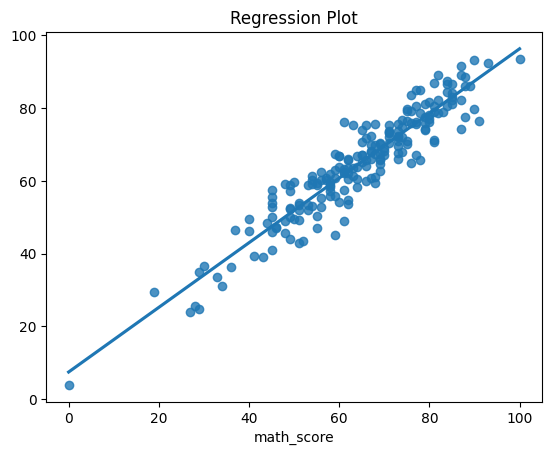

In [82]:
fig= plt.Figure(figsize= (10,6))
y_pred= best_model.predict(X_test)
sns.regplot(x= y_test, 
            y= y_pred,
            ci= None,

            )
plt.title("Regression Plot")
plt.show()

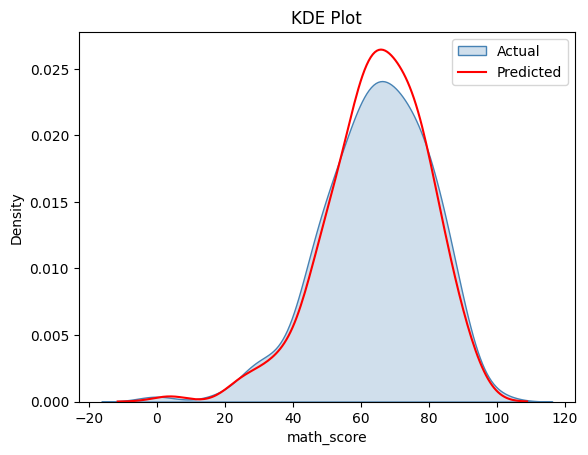

In [83]:
sns.kdeplot(x= y_test, color= 'steelblue', label= 'Actual', fill= True)
sns.kdeplot(x= y_pred, color= 'red', label= 'Predicted')
plt.title('KDE Plot')
plt.legend()
plt.show()